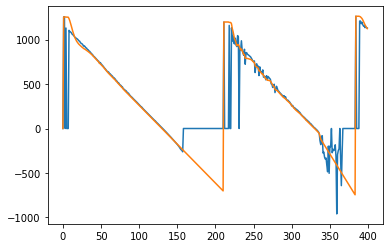

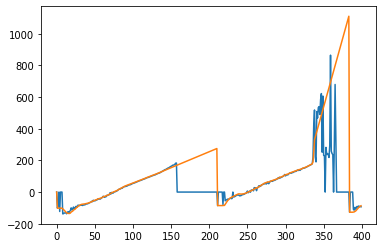

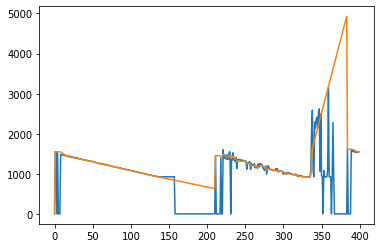

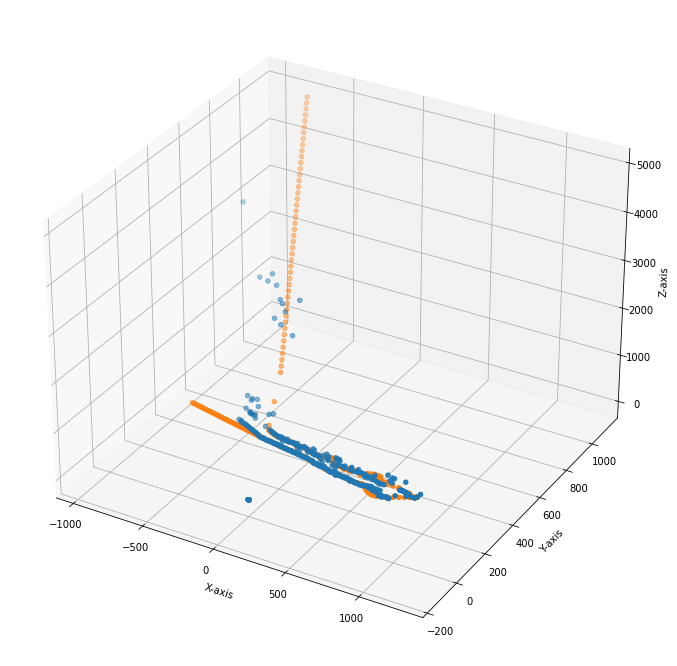

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

START, END = 0, -1 #100, 500
SAVE = False

leftImages = glob.glob('./Stereo_conveyor_without_occlusions/left/*.png')
rightImages = glob.glob('./Stereo_conveyor_without_occlusions/right/*.png')

rect_map_left_x = np.load(r'matrix_calib_rectify\map_left_x.npy')
rect_map_left_y = np.load(r'matrix_calib_rectify\map_left_y.npy')
rect_map_right_x = np.load(r'matrix_calib_rectify\map_right_x.npy')
rect_map_right_y = np.load(r'matrix_calib_rectify\map_right_y.npy')
mtx_P_l = np.load(r'matrix_calib_rectify\projection_matrix_left.npy')
mtx_P_r = np.load(r'matrix_calib_rectify\projection_matrix_right.npy')


def findobjectbounds(frame, bgs):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    belt_mask = cv2.bitwise_not(cv2.inRange(hsv, np.array([100,50,50]), 
                                                 np.array([115,255,255])))

    result = cv2.bitwise_and(frame, frame, mask=belt_mask)

    fgMask = bgs.apply(result)

    kernel = np.ones((5,5), np.uint8) 
    fgMask = cv2.dilate(fgMask, kernel, iterations=1) 
    fgMask = cv2.erode(fgMask, kernel, iterations=1) 

    contours, _ = cv2.findContours(fgMask,2,1)         

    pts = np.array([[410, 490],
                    [1110,310],
                    [1250,370],
                    [460,660]], np.int32)
    pts = pts.reshape((-1,1,2))

    for c in reversed(sorted(contours, key=cv2.contourArea)):
        ((center_x, center_y), radius) = cv2.minEnclosingCircle(c)
        if radius > 30 and radius < 200:
            if cv2.pointPolygonTest(pts, (center_x, center_y), False) > 0:
                return True, center_x, center_y, radius
        break
    return False, 0, 0, 0
    
def computeDisparity(x_center, y_center, left, right, gap=5): #left and right undistoreted and rectified images (3 channels)
    stereo = cv2.StereoSGBM_create(minDisparity=0,
                                   numDisparities=int((1280 / 8) + 15) & -16,#160
                                   blockSize=5,
                                   P1=8*3*5**2, #600
                                   P2=32*3*5**2, #2400
                                   disp12MaxDiff=100,
                                   preFilterCap=32,
                                   uniquenessRatio=10,
                                   speckleWindowSize=0,
                                   speckleRange=32)

    left = left[y_center-gap*2:y_center+gap*2, 0:-1]
    right = right[y_center-gap*2:y_center+gap*2, 0:-1]

    disp = stereo.compute(left, right)
    disp = cv2.medianBlur(disp, 5)

    disp_list = [0]#if depth is not found zero is returned
    for x in [x_center-gap, x_center, x_center+gap]:
        for y in [gap*2-gap, gap*2, gap*2+gap]:
            disp_list.append((disp[y,x]))

    result = max(disp_list)
    #print(result)
    #if result:
    #    return 0, 0
    return result

def kalmanInit(init_state):
    kalman = cv2.KalmanFilter(6, 3, 0)
    kalman.transitionMatrix = np.array([[1, 1, 0, 0, 0, 0],
                                        [0, 1, 0, 0, 0, 0],
                                        [0, 0, 1, 1, 0, 0],
                                        [0, 0, 0, 1, 0, 0],
                                        [0, 0, 0, 0, 1, 1],
                                        [0, 0, 0, 0, 0, 1]], np.float32)
    kalman.processNoiseCov = 1e-5 * np.eye(6, dtype=np.float32)
    kalman.measurementNoiseCov = 1e-2 * np.eye(3, dtype=np.float32)
    kalman.errorCovPost = 1. * np.eye(6, dtype=np.float32)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0, 0, 0],
                                         [0, 0, 1, 0, 0, 0],
                                         [0, 0, 0, 0, 1, 0]], np.float32)
    kalman.statePre = init_state
    return kalman

def getMeasure(rect_left, rect_right, backSub):
    founded, center_x, center_y, radius = findobjectbounds(frame, backSub)
    if founded:
        disp = computeDisparity(int(center_x), int(center_y), rect_left, rect_right)
        if disp == 0:
            return False, 0, 0, 0, 0
        else:
            return True, center_x, center_y, radius, disp
    return False, 0, 0, 0, 0

frame = cv2.imread(leftImages[0])
frame = cv2.remap(frame, rect_map_left_x, rect_map_left_y, cv2.INTER_LINEAR)

backSub = cv2.createBackgroundSubtractorMOG2(30, 16, False)
_ = backSub.apply(frame)

measure_history = []
prediction_history = []
initialized, kalman = False, False

for i, (imgL, imgR) in enumerate(zip(leftImages[START:END], rightImages[START:END])):
    frame = cv2.imread(imgL)
    frame = cv2.remap(frame, rect_map_left_x, rect_map_left_y, cv2.INTER_LINEAR)
    rect_left = frame.copy()

    frame_right = cv2.imread(imgR)
    rect_right = cv2.remap(frame_right, rect_map_right_x, rect_map_right_y, cv2.INTER_LINEAR)

    founded, center_x, center_y, radius, disp = getMeasure(rect_left, rect_right, backSub) 

    if SAVE and founded and i%10==0:
        roi = frame[int(center_y-radius):int(center_y+radius), 
                    int(center_x-radius):int(center_x+radius)]
        resized_roi = cv2.resize(roi, (100, 100), interpolation= cv2.INTER_LINEAR)
        cv2.imwrite(r".\saved_roi\frame_{}.png".format(i), resized_roi)

    if founded:
        cv2.circle(frame, (int(center_x), int(center_y)), int(radius), (0, 0, 255), 2) #cirle
        cv2.circle(frame, (int(center_x), int(center_y)), 5, (0, 0, 255), -1) #center

        center_3d_homogeneous = cv2.triangulatePoints(mtx_P_l, mtx_P_r, np.array([[center_x], [center_y]]), np.array([[center_x-disp], [center_y]]))
        center_3d = cv2.transpose(center_3d_homogeneous)
        center_3d = cv2.convertPointsFromHomogeneous(center_3d).squeeze()

        if center_x > 1090 and not initialized:
            #"""
            kalman = kalmanInit(np.array([[center_3d[0]], 
                                          [0], 
                                          [center_3d[1]], 
                                          [0], 
                                          [center_3d[2]], 
                                          [0]], np.float32))

            initialized = True
            cv2.putText(frame,'Filter initialized', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, 2)

        if center_x < 600 and initialized:
            initialized = False

        if initialized:
            kalman.correct(np.array([[center_3d[0]],
                                     [center_3d[1]],
                                     [center_3d[2]]], dtype=np.float32))

    if kalman:
        ### Predict the next state
        pred = kalman.predict()

        ### Draw the current tracked state and the predicted state on the image frame ###
        x_pred, y_pred, z_pred = np.matmul(kalman.measurementMatrix, pred).ravel()

        point, _ = cv2.projectPoints(np.array([x_pred, y_pred, z_pred]), (0, 0, 0), (0, 0, 0), mtx_P_l[:, 0:-1], None)

        point_x = point[0][0][0]
        point_y = point[0][0][1]
        cv2.circle(frame,(int(point_x), int(point_y)), 5, (255,0,0),-1)

        prediction_history.append((x_pred*1000, y_pred*1000, z_pred*1000))
    else:
        prediction_history.append((0, 0, 0))
    
    if founded:
        measure_history.append((center_3d[0]*1000, center_3d[1]*1000, center_3d[2]*1000))
    else:
        measure_history.append((0, 0, 0))

    text = 'Frame: {}; Prediction: X: {:.1f}; Y: {:.1f}; Z: {:.1f}'.format(i, *prediction_history[-1])
    cv2.putText(frame,text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, 2)
   
    # Show the frame
    cv2.imshow('Frame', frame)
    cv2.waitKey(50)

cv2.destroyAllWindows()


x_meas = [i[0] for i in measure_history]
y_meas = [i[1] for i in measure_history]
z_meas = [i[2] for i in measure_history]
x_pred = [i[0] for i in prediction_history]
y_pred = [i[1] for i in prediction_history]
z_pred = [i[2] for i in prediction_history]

plt.plot(x_meas)
plt.plot(x_pred)
plt.figure()
plt.plot(y_meas)
plt.plot(y_pred)
plt.figure()
plt.plot(z_meas)
plt.plot(z_pred)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_meas, y_meas, z_meas)
ax.scatter(x_pred, y_pred, z_pred)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()